In [0]:
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import glob
from PIL import Image
import torch
from torch import nn, optim

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!tar -zxvf "../content/gdrive/My Drive/datasets/coco.tar.gz"

In [0]:
root_path = "coco"

# create data_loader for images
class SaliencyDataset(Dataset):
    def __init__(self, mode='train'):
        self.heatmap_path_list = glob.glob(f"{root_path}/heatmaps/COCO_{mode}*.jpg")
        
    def __getitem__(self, index):
        heatmap_path = self.heatmap_path_list[index]
        image_path = f"{root_path}/images/"+heatmap_path.split('/')[-1]
                
        heatmap = Image.open(heatmap_path)
        image = Image.open(image_path).convert('RGB')
        
        to_tensot = transforms.ToTensor()
        resize_240 = transforms.Resize(240)
        resize_30 = transforms.Resize(30)
        
        return to_tensot(resize_30(heatmap)), to_tensot(resize_240(image))

    def __len__(self):
        return len(self.heatmap_path_list)

In [0]:
batch_size = 8

dataset = SaliencyDataset()
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

dataset_val = SaliencyDataset('val')
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True, num_workers=2)

torch.Size([8, 1, 30, 40]) torch.Size([8, 3, 240, 320])


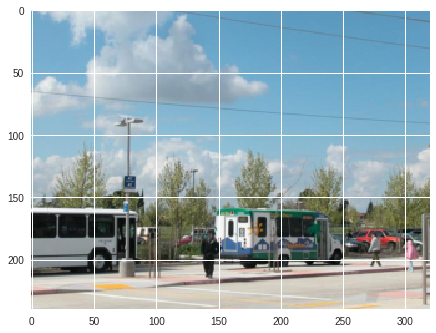

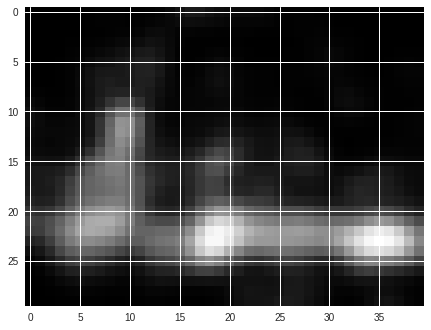

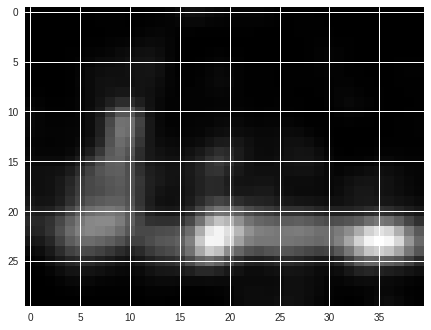

In [27]:
heatmaps, images = next(iter(loader))

print(heatmaps.shape, images.shape)

plt.imshow(images[0].permute(1, 2, 0))
plt.show()

heatmap = heatmaps[0].view(30, 40)
plt.imshow(heatmap, cmap='Greys_r')
plt.show()

heatmap = torch.softmax(heatmaps[0].view(-1), dim=0).view(30, 40)
plt.imshow(heatmap, cmap='Greys_r')
plt.show()

In [0]:
class ResBlock(nn.Module):
    def __init__(self, channels):
        super(ResBlock, self).__init__()
        
        self.resblock = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, kernel_size=3),
            nn.InstanceNorm2d(channels, affine=True),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, kernel_size=3),
            nn.InstanceNorm2d(channels, affine=True),
        )
        
    def forward(self, x):
        out = self.resblock(x)
        return out + x
    
class Upsample2d(nn.Module):
    def __init__(self, scale_factor):
        super(Upsample2d, self).__init__()
        
        self.interp = nn.functional.interpolate
        self.scale_factor = scale_factor
        
    def forward(self, x):
        x = self.interp(x, scale_factor=self.scale_factor, mode='nearest')
        return x

class MicroResNet(nn.Module):
    def __init__(self):
        super(MicroResNet, self).__init__()
        
        self.downsampler = nn.Sequential(
            nn.ReflectionPad2d(4),
            nn.Conv2d(3, 8, kernel_size=9, stride=4),
            nn.InstanceNorm2d(8, affine=True),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 16, kernel_size=3, stride=2),
            nn.InstanceNorm2d(16, affine=True),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(16, 32, kernel_size=3, stride=2),
            nn.InstanceNorm2d(32, affine=True),
            nn.ReLU(),
        )
        
        self.residual = nn.Sequential(
            ResBlock(32),
            nn.Conv2d(32, 64, kernel_size=1, bias=False, groups=32),
            ResBlock(64),
        )
        
        self.segmentator = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 16, kernel_size=3),
            nn.InstanceNorm2d(16, affine=True),
            nn.ReLU(),
            Upsample2d(scale_factor=2),
            nn.ReflectionPad2d(4),
            nn.Conv2d(16, 1, kernel_size=9),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        out = self.downsampler(x)
        out = self.residual(out)
        out = self.segmentator(out)
        return out

In [0]:
model = MicroResNet()

In [30]:
heatmaps, images = next(iter(loader))

pred = model(images)
print(pred.shape, heatmaps.shape)

torch.Size([8, 1, 30, 40]) torch.Size([8, 1, 30, 40])


In [43]:
epochs = 15

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

model.cuda()
for e in range(1, epochs+1):
    scheduler.step()
    total_loss = 0
    total_acc = 0
    valid_loss = 0
    valid_acc = 0
    batch = 0
    model.train()
    for heatmaps, images in loader:
        heatmaps, images = heatmaps.cuda(), images.cuda()
        batch += 1
        optimizer.zero_grad()
        batch_size = images.size(0)

        pred = model.forward(images)
        
        pred_softmax = torch.softmax(pred.view(batch_size, -1), dim=1)
        heatmaps_softmax = torch.softmax(heatmaps.view(batch_size, -1), dim=1)
        loss = criterion(pred, heatmaps)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # accuracy 
        pred_binary = torch.zeros_like(pred)
        pred_binary[ pred > (pred.max()*0.25) ] = 1
        
        heatmaps_binary = torch.zeros_like(heatmaps)
        heatmaps_binary[ heatmaps > (heatmaps.max()*0.25) ] = 1
        
        equals = pred_binary == heatmaps_binary
        accuracy = torch.mean(equals.type(torch.FloatTensor))
        total_acc += accuracy
        
        if batch % 125 == 0:
            print(f"EPOCH {e} ({batch}/{len(loader)}) - loss {total_loss/batch:.4f} - acc {total_acc/batch:.4f}")
          
    model.eval()
    with torch.no_grad():
        for heatmaps, images in loader_val: 
            heatmaps, images = heatmaps.cuda(), images.cuda()
            batch_size = images.size(0)
            
            pred = model.forward(images)
            
            pred_softmax = torch.softmax(pred.view(batch_size, -1), dim=1)
            heatmaps_softmax = torch.softmax(heatmaps.view(batch_size, -1), dim=1)
            loss = criterion(pred, heatmaps)
            valid_loss += loss
            
            # accuracy
            pred_binary = torch.zeros_like(pred)
            pred_binary[ pred > (pred.max()*0.25) ] = 1

            heatmaps_binary = torch.zeros_like(heatmaps)
            heatmaps_binary[ heatmaps > (heatmaps.max()*0.25) ] = 1

            equals = pred_binary == heatmaps_binary
            accuracy = torch.mean(equals.type(torch.FloatTensor))
            valid_acc += accuracy
    
    print(f"EPOCH {e} ({len(loader)}/{len(loader)}) - loss {total_loss/len(loader):.4f} - acc {total_acc/len(loader):.4f} - val_loss: {valid_loss/len(loader_val):.4f} - valid_acc: {valid_acc/len(loader_val):.4f}")

EPOCH 1 (125/1250) - loss 0.0109 - acc 0.8552
EPOCH 1 (250/1250) - loss 0.0111 - acc 0.8535
EPOCH 1 (375/1250) - loss 0.0110 - acc 0.8553
EPOCH 1 (500/1250) - loss 0.0110 - acc 0.8562
EPOCH 1 (625/1250) - loss 0.0109 - acc 0.8571
EPOCH 1 (750/1250) - loss 0.0109 - acc 0.8564
EPOCH 1 (875/1250) - loss 0.0109 - acc 0.8565
EPOCH 1 (1000/1250) - loss 0.0109 - acc 0.8562
EPOCH 1 (1125/1250) - loss 0.0109 - acc 0.8564
EPOCH 1 (1250/1250) - loss 0.0109 - acc 0.8558
EPOCH 1 (1250/1250) - loss 0.0109 - acc 0.8558 - val_loss: 0.0117 - valid_acc: 0.8490
EPOCH 2 (125/1250) - loss 0.0106 - acc 0.8585
EPOCH 2 (250/1250) - loss 0.0107 - acc 0.8582
EPOCH 2 (375/1250) - loss 0.0107 - acc 0.8573
EPOCH 2 (500/1250) - loss 0.0106 - acc 0.8582
EPOCH 2 (625/1250) - loss 0.0107 - acc 0.8583
EPOCH 2 (750/1250) - loss 0.0107 - acc 0.8584
EPOCH 2 (875/1250) - loss 0.0108 - acc 0.8575
EPOCH 2 (1000/1250) - loss 0.0108 - acc 0.8570
EPOCH 2 (1125/1250) - loss 0.0108 - acc 0.8574
EPOCH 2 (1250/1250) - loss 0.0109 -

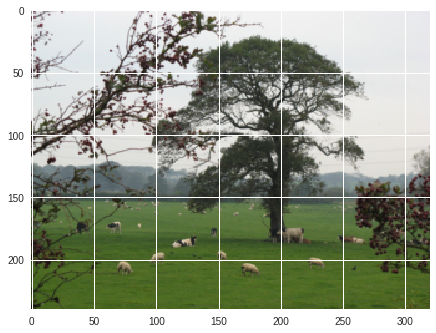

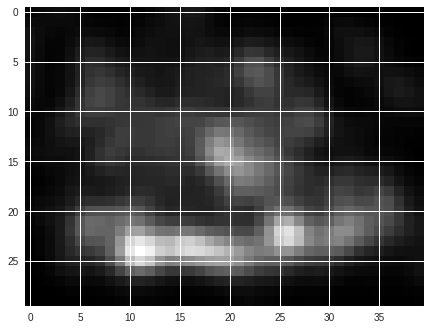

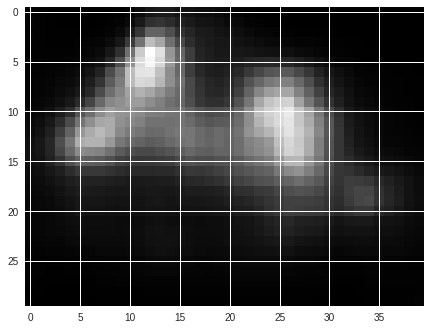

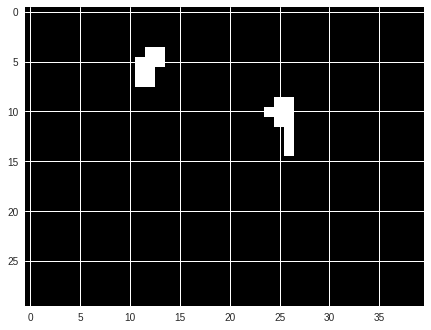

CENTER tensor(19.0118) tensor(13.3727)


In [48]:
with torch.no_grad():
    model.eval()
    model.cuda()
    heatmaps, images = next(iter(loader_val))

    preds = model(images.cuda()).cpu()

    plt.imshow(images[0].permute(1, 2, 0))
    plt.show()

    heatmap = torch.softmax(heatmaps[0].view(-1), dim=0).view(30, 40)
    plt.imshow(heatmap, cmap='Greys_r')
    plt.show()

    temperature = 0.25
    tempered_pred = torch.log(torch.softmax(preds[0].view(-1), dim=0)) / temperature
    tempered_pred = torch.exp(tempered_pred) / torch.sum(torch.exp(tempered_pred))
    
    pred = tempered_pred.view(30, 40)
    plt.imshow(pred, cmap='Greys_r')
    plt.show()
    
    pred_bin = torch.zeros_like(pred)
    pred_bin[pred >= pred.max()*0.75] = 1
    plt.imshow(pred_bin, cmap='Greys_r')
    plt.show()
    
    center_x, center_y = 0, 0
    for i in range(pred.size(0)):
        for j in range(pred.size(1)):
            center_x += j * pred[i, j]
            center_y += i * pred[i, j]
    
    print("CENTER", center_x, center_y)

In [0]:
model.cpu()
torch.save(model.state_dict(), 'gdrive/My Drive/Colab Notebooks/model_fast.pt')

In [0]:
## VALIDATE MODEL

# create data_loader for images
class TestDataset(Dataset):
    def __init__(self):
        self.image_path_list = glob.glob(f"gdrive/My Drive/datasets/test_images/*.jpg")
        
    def __getitem__(self, index):
        image_path = self.image_path_list[index]
                
        image = Image.open(image_path).convert('RGB')
        
        to_tensot = transforms.ToTensor()
        resize_240 = transforms.Resize(240)
        
        return to_tensot(resize_240(image))

    def __len__(self):
        return len(self.image_path_list)
      
dataset_test = TestDataset()
loader_test = DataLoader(dataset_test, batch_size=1)

In [ ]:
with torch.no_grad():
    model.eval()
    model.cuda()
    
    for images in loader_test:
        preds = model(images.cuda()).cpu()
        heatmap_h = preds.size(2)
        heatmap_w = preds.size(3)

        plt.imshow(images[0].permute(1, 2, 0))
        plt.show()

        temperature = 0.25
        tempered_pred = torch.log(torch.softmax(preds[0].view(-1), dim=0)) / temperature
        tempered_pred = torch.exp(tempered_pred) / torch.sum(torch.exp(tempered_pred))

        pred = tempered_pred.view(heatmap_h, heatmap_w)
        plt.imshow(pred, cmap='Greys_r')
        plt.show()